<a href="https://colab.research.google.com/github/Olamaryse/autism-prediction/blob/main/Autism_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

## Data

* ID - ID of the patient
* A1_Score to A10_Score - Score based on Autism Spectrum Quotient (AQ) 10 item screening tool
* age - Age of the patient in years
* gender - Gender of the patient
* ethnicity - Ethnicity of the patient
* jaundice - Whether the patient had jaundice at the time of birth
* autism - Whether an immediate family member has been diagnosed with autism
* contry_of_res - Country of residence of the patient
* used_app_before - Whether the patient has undergone a screening test before
* result - Score for AQ1-10 screening test
* age_desc - Age of the patient
* relation - Relation of patient who completed the test
* Class/ASD - Classified result as 0 or 1. Here 0 represents No and 1 represents Yes. This is the target column, and during submission submit the values as 0 or 1 only.

In [2]:
df = pd.read_csv('drive/MyDrive/Autism Prediction/train.csv')
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [4]:
# convert float to int
df['age'] = df['age'].astype(int)

In [5]:
for col in df.columns:
  numerical_features = ['age', 'result', 'ID']
  if col not in numerical_features:
    print(col, df[col].unique())
    print("-"*50)

A1_Score [1 0]
--------------------------------------------------
A2_Score [0 1]
--------------------------------------------------
A3_Score [1 0]
--------------------------------------------------
A4_Score [0 1]
--------------------------------------------------
A5_Score [1 0]
--------------------------------------------------
A6_Score [0 1]
--------------------------------------------------
A7_Score [1 0]
--------------------------------------------------
A8_Score [0 1]
--------------------------------------------------
A9_Score [1 0]
--------------------------------------------------
A10_Score [1 0]
--------------------------------------------------
gender ['f' 'm']
--------------------------------------------------
ethnicity ['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others']
--------------------------------------------------
jaundice ['no' 'yes']
--------------------------------------------------
austim

In [6]:
# Dropping ID & age_des column
df = df.drop(columns=['ID', 'age_desc'])

In [7]:
df['contry_of_res'].unique()

array(['Austria', 'India', 'United States', 'South Africa', 'Jordan',
       'United Kingdom', 'Brazil', 'New Zealand', 'Canada', 'Kazakhstan',
       'United Arab Emirates', 'Australia', 'Ukraine', 'Iraq', 'France',
       'Malaysia', 'Viet Nam', 'Egypt', 'Netherlands', 'Afghanistan',
       'Oman', 'Italy', 'AmericanSamoa', 'Bahamas', 'Saudi Arabia',
       'Ireland', 'Aruba', 'Sri Lanka', 'Russia', 'Bolivia', 'Azerbaijan',
       'Armenia', 'Serbia', 'Ethiopia', 'Sweden', 'Iceland', 'Hong Kong',
       'Angola', 'China', 'Germany', 'Spain', 'Tonga', 'Pakistan', 'Iran',
       'Argentina', 'Japan', 'Mexico', 'Nicaragua', 'Sierra Leone',
       'Czech Republic', 'Niger', 'Romania', 'Cyprus', 'Belgium',
       'Burundi', 'Bangladesh'], dtype=object)

In [8]:
# define the mapping dictionary for country names
mapping = {
    'Viet nam': 'Vietnam',
    'AmericanSamoa': 'United States',
    'Hong Kong': 'China'
}

# replace the cvalue in the country column
df['contry_of_res'] = df['contry_of_res'].replace(mapping)


In [9]:
df['contry_of_res'].unique()

array(['Austria', 'India', 'United States', 'South Africa', 'Jordan',
       'United Kingdom', 'Brazil', 'New Zealand', 'Canada', 'Kazakhstan',
       'United Arab Emirates', 'Australia', 'Ukraine', 'Iraq', 'France',
       'Malaysia', 'Viet Nam', 'Egypt', 'Netherlands', 'Afghanistan',
       'Oman', 'Italy', 'Bahamas', 'Saudi Arabia', 'Ireland', 'Aruba',
       'Sri Lanka', 'Russia', 'Bolivia', 'Azerbaijan', 'Armenia',
       'Serbia', 'Ethiopia', 'Sweden', 'Iceland', 'China', 'Angola',
       'Germany', 'Spain', 'Tonga', 'Pakistan', 'Iran', 'Argentina',
       'Japan', 'Mexico', 'Nicaragua', 'Sierra Leone', 'Czech Republic',
       'Niger', 'Romania', 'Cyprus', 'Belgium', 'Burundi', 'Bangladesh'],
      dtype=object)

In [10]:
# target class distribution
df['Class/ASD'].value_counts()

,count
Class/ASD,
0,639
1,161


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         800 non-null    int64  
 1   A2_Score         800 non-null    int64  
 2   A3_Score         800 non-null    int64  
 3   A4_Score         800 non-null    int64  
 4   A5_Score         800 non-null    int64  
 5   A6_Score         800 non-null    int64  
 6   A7_Score         800 non-null    int64  
 7   A8_Score         800 non-null    int64  
 8   A9_Score         800 non-null    int64  
 9   A10_Score        800 non-null    int64  
 10  age              800 non-null    int64  
 11  gender           800 non-null    object 
 12  ethnicity        800 non-null    object 
 13  jaundice         800 non-null    object 
 14  austim           800 non-null    object 
 15  contry_of_res    800 non-null    object 
 16  used_app_before  800 non-null    object 
 17  result          

## Univariate Analysis

Numerical columns:
* age
* result

In [12]:
# Set the desired theme
sns.set_theme(style="darkgrid")

Mean Age: 27.96375
Median Age: 24.0


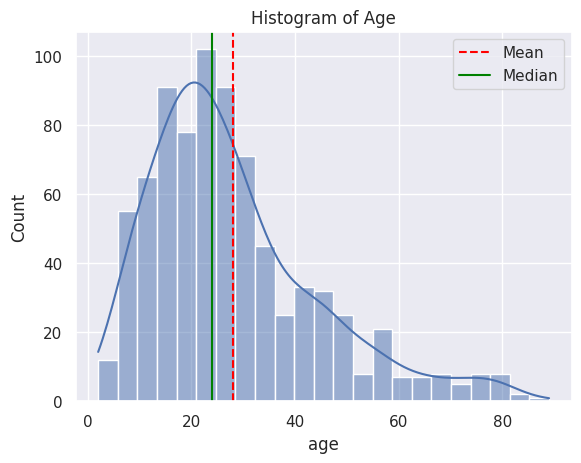

In [13]:
# Histogram for'age'
sns.histplot(df['age'], kde=True)
plt.title('Histogram of Age')

# Calculate thhe mean and median
mean_age = df['age'].mean()
median_age = df['age'].median()

print('Mean Age:', mean_age)
print('Median Age:', median_age)

# add vertical lines for mean and median
plt.axvline(mean_age, color='red', linestyle='--', label='Mean')
plt.axvline(median_age, color='green', linestyle='-', label='Median')

plt.legend()
plt.show()

Mean result: 8.537303106501248
Median result: 9.605299308


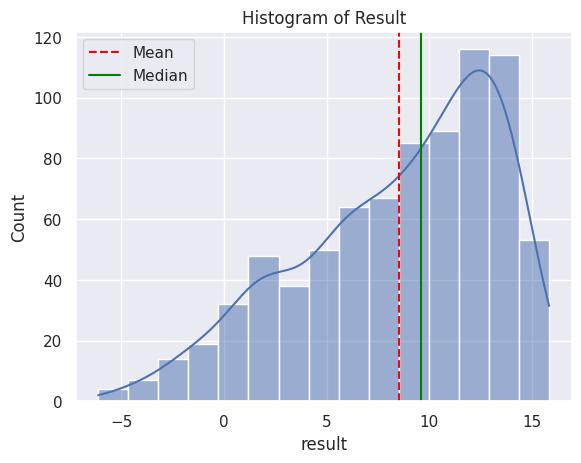

In [14]:
# Histogram for'result'
sns.histplot(df['result'], kde=True)
plt.title('Histogram of Result')

# Calculate thhe mean and median
mean_result = df['result'].mean()
median_result = df['result'].median()

print('Mean result:', mean_result)
print('Median result:', median_result)

# add vertical lines for mean and median
plt.axvline(mean_result, color='red', linestyle='--', label='Mean')
plt.axvline(median_result, color='green', linestyle='-', label='Median')

plt.legend()
plt.show()

Box plot for identifying outliers in the numerical columns

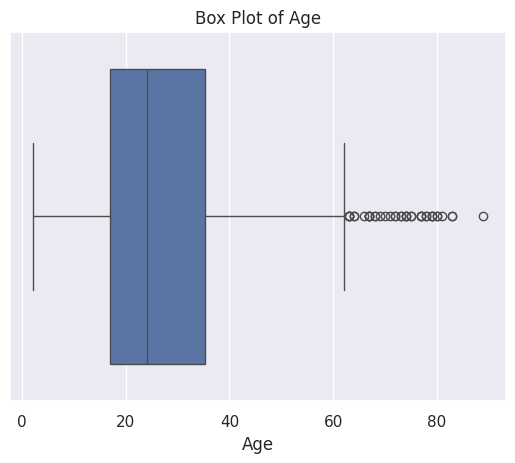

In [15]:
# Box plot
sns.boxplot(x=df['age'])
plt.title('Box Plot of Age')
plt.xlabel('Age')
plt.show()

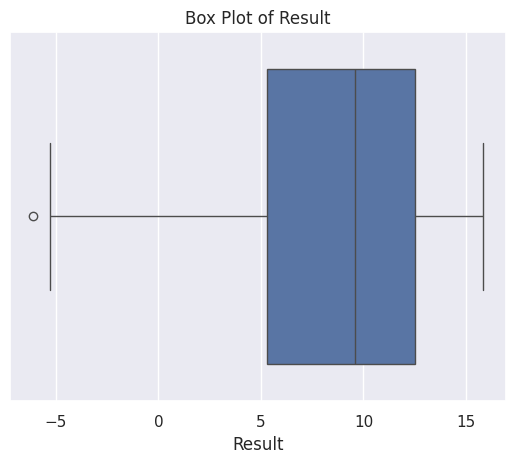

In [16]:
sns.boxplot(x=df['result'])
plt.title('Box Plot of Result')
plt.xlabel('Result')
plt.show()

In [17]:
# Count the outliers using IQR method
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
age_outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]

In [18]:
len(age_outliers)

39

In [19]:
Q1 = df['result'].quantile(0.25)
Q3 = df['result'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
result_outliers = df[(df['result'] < lower_bound) | (df['result'] > upper_bound)]

In [20]:
len(result_outliers)

1

## Univariate analysis of Categorical columns

In [21]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

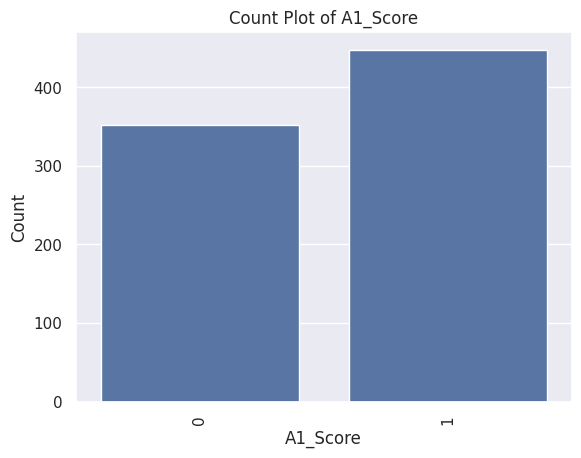

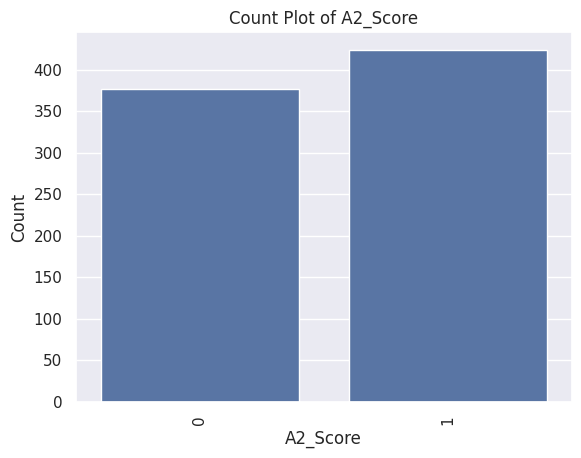

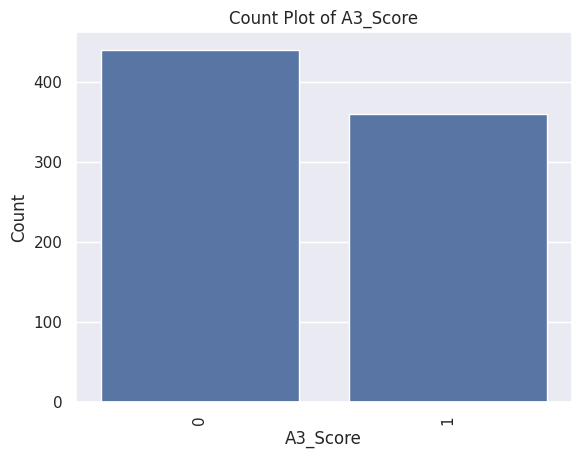

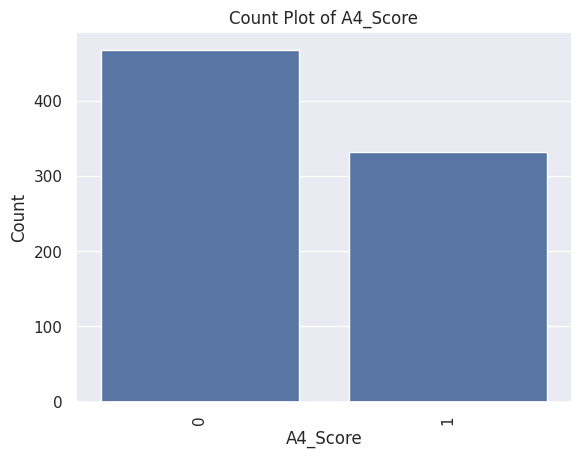

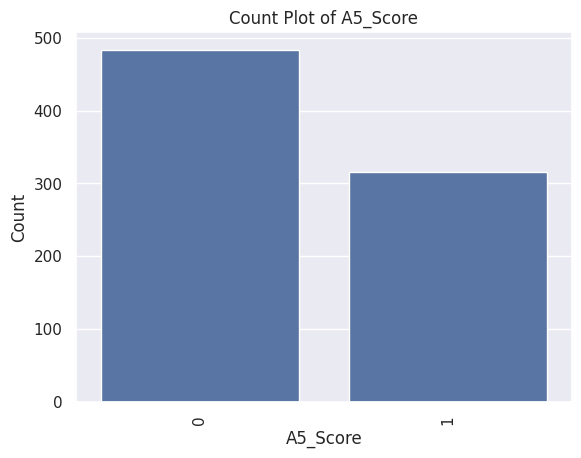

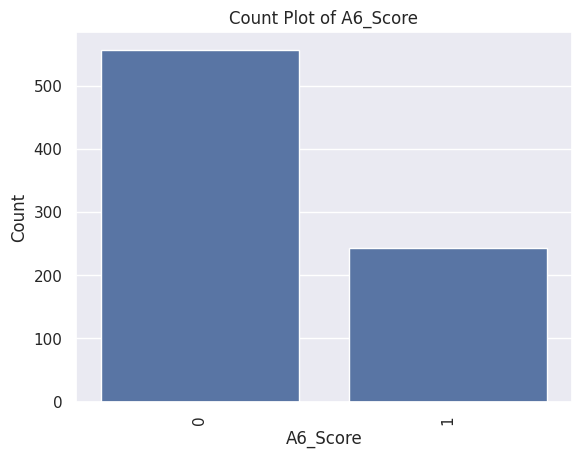

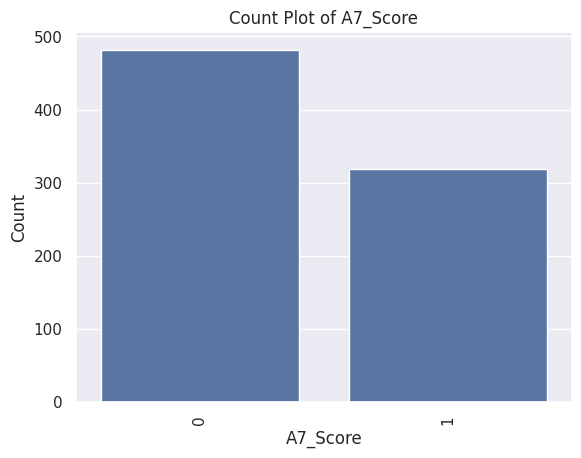

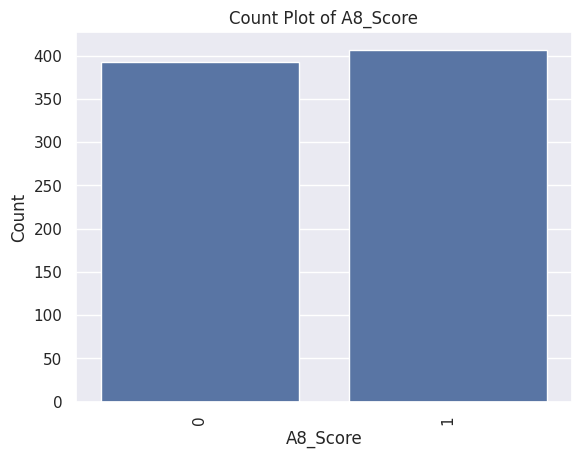

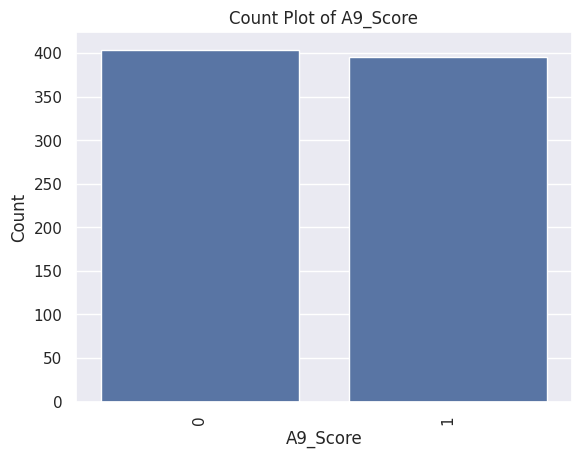

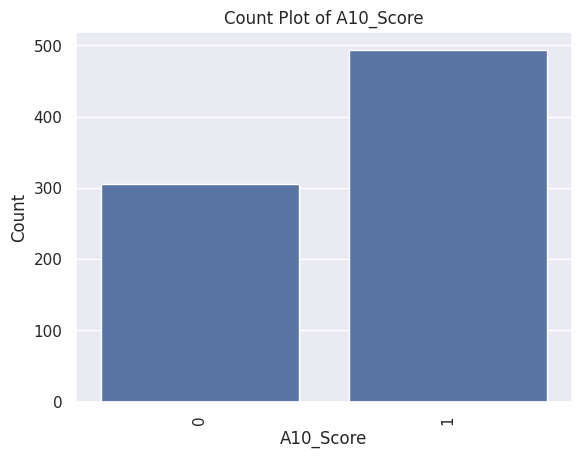

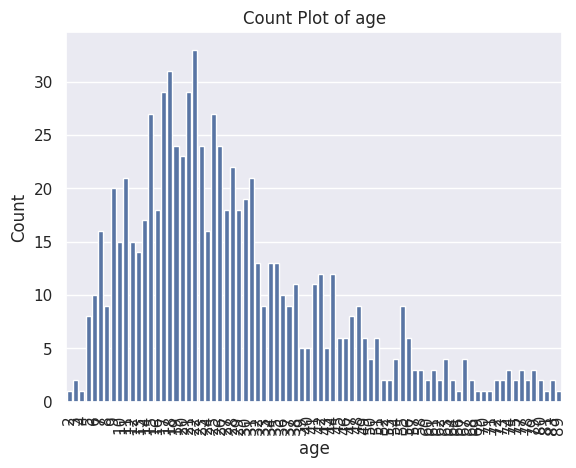

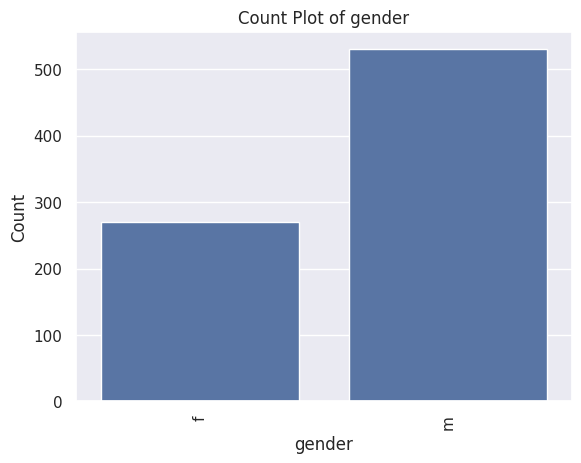

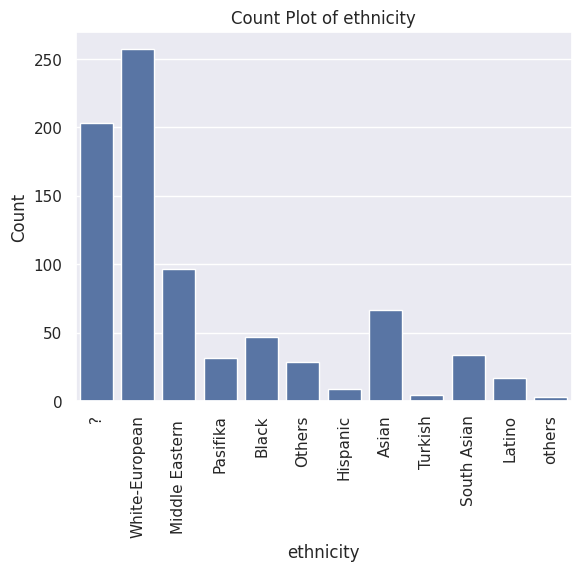

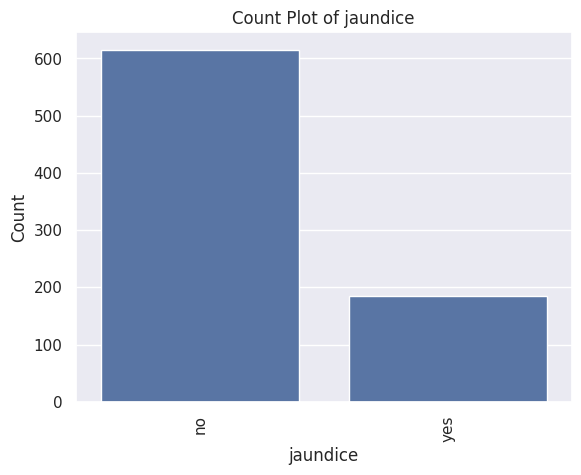

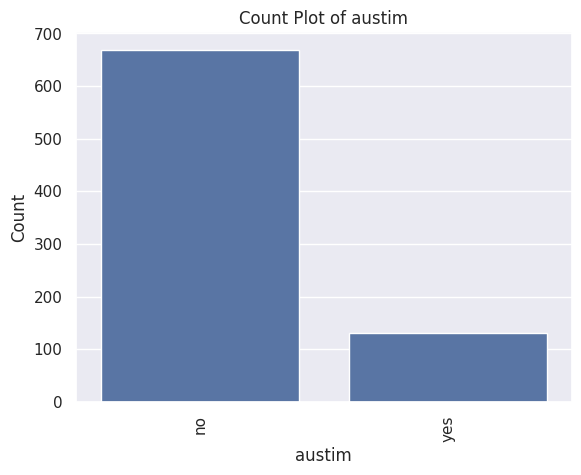

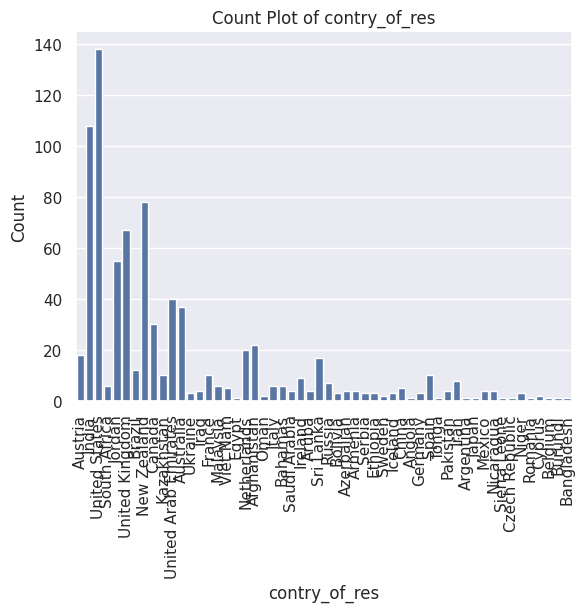

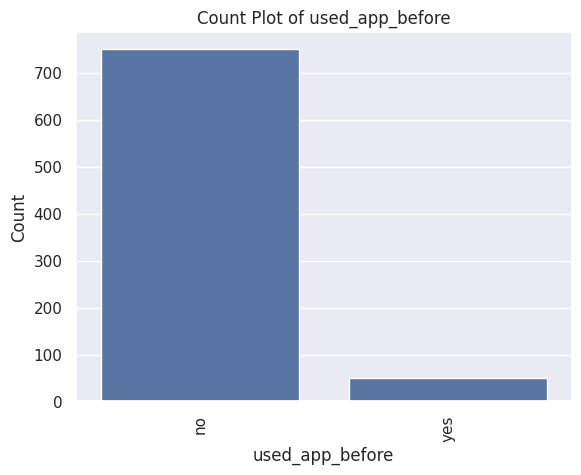

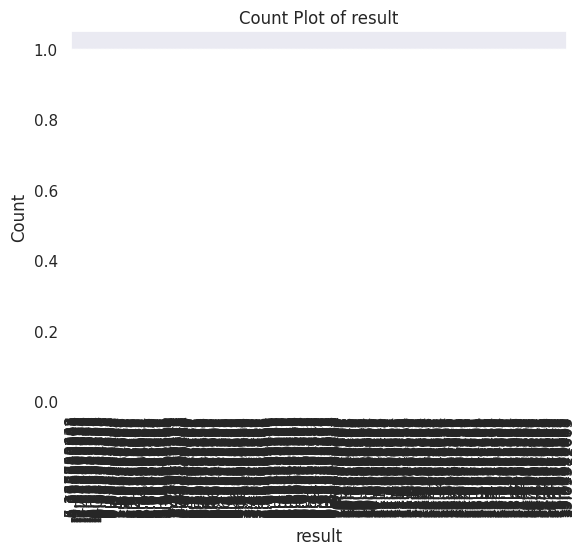

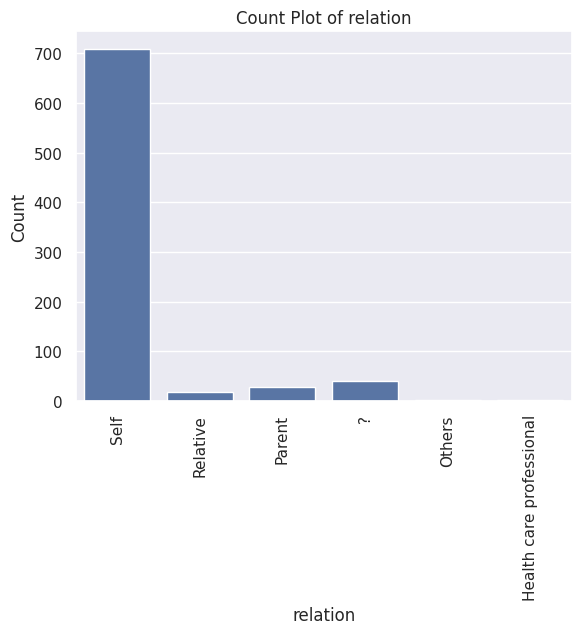

In [22]:
categorical_columns = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation']

for col in categorical_columns:
  sns.countplot(x=df[col])
  plt.title(f'Count Plot of {col}')
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.xticks(rotation=90)
  plt.show()


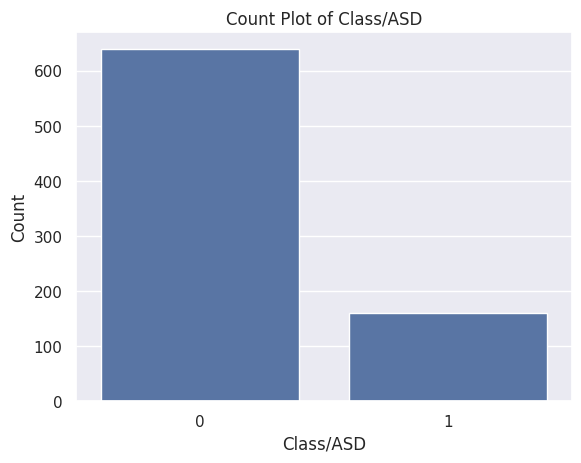

In [23]:
# countplot for target column (Class/ASD)
sns.countplot(x=df['Class/ASD'])
plt.title('Count Plot of Class/ASD')
plt.xlabel('Class/ASD')
plt.ylabel('Count')
plt.show()

In [24]:
df["Class/ASD"].value_counts()

,count
Class/ASD,
0,639
1,161


Handle the missing value in ethinicity and relation column

In [25]:
df["ethnicity"] = df["ethnicity"].replace({"?": "Others", "Others" : "Others"})
df["relation"] = df["relation"].replace({"?": "Others",
                                         "Relative" : "Others",
                                         "Parent" : "Others",
                                         "Health care professional" : "Others"})

In [26]:
df["relation"].unique()

array(['Self', 'Others'], dtype=object)

## Label Encoding

In [27]:
# Identify "object" dtypes
object_columns = df.select_dtypes(include = ["object"]).columns
object_columns

Index(['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'used_app_before', 'relation'],
      dtype='object')

In [28]:
# Initalize dict to store encoder
encoders = {}

# apply label encoding and store the encoders
for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column] = label_encoder #saving the encoder for this column

  # save the encoders as a pickle file
  with open('encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

## Bivariate Analysis

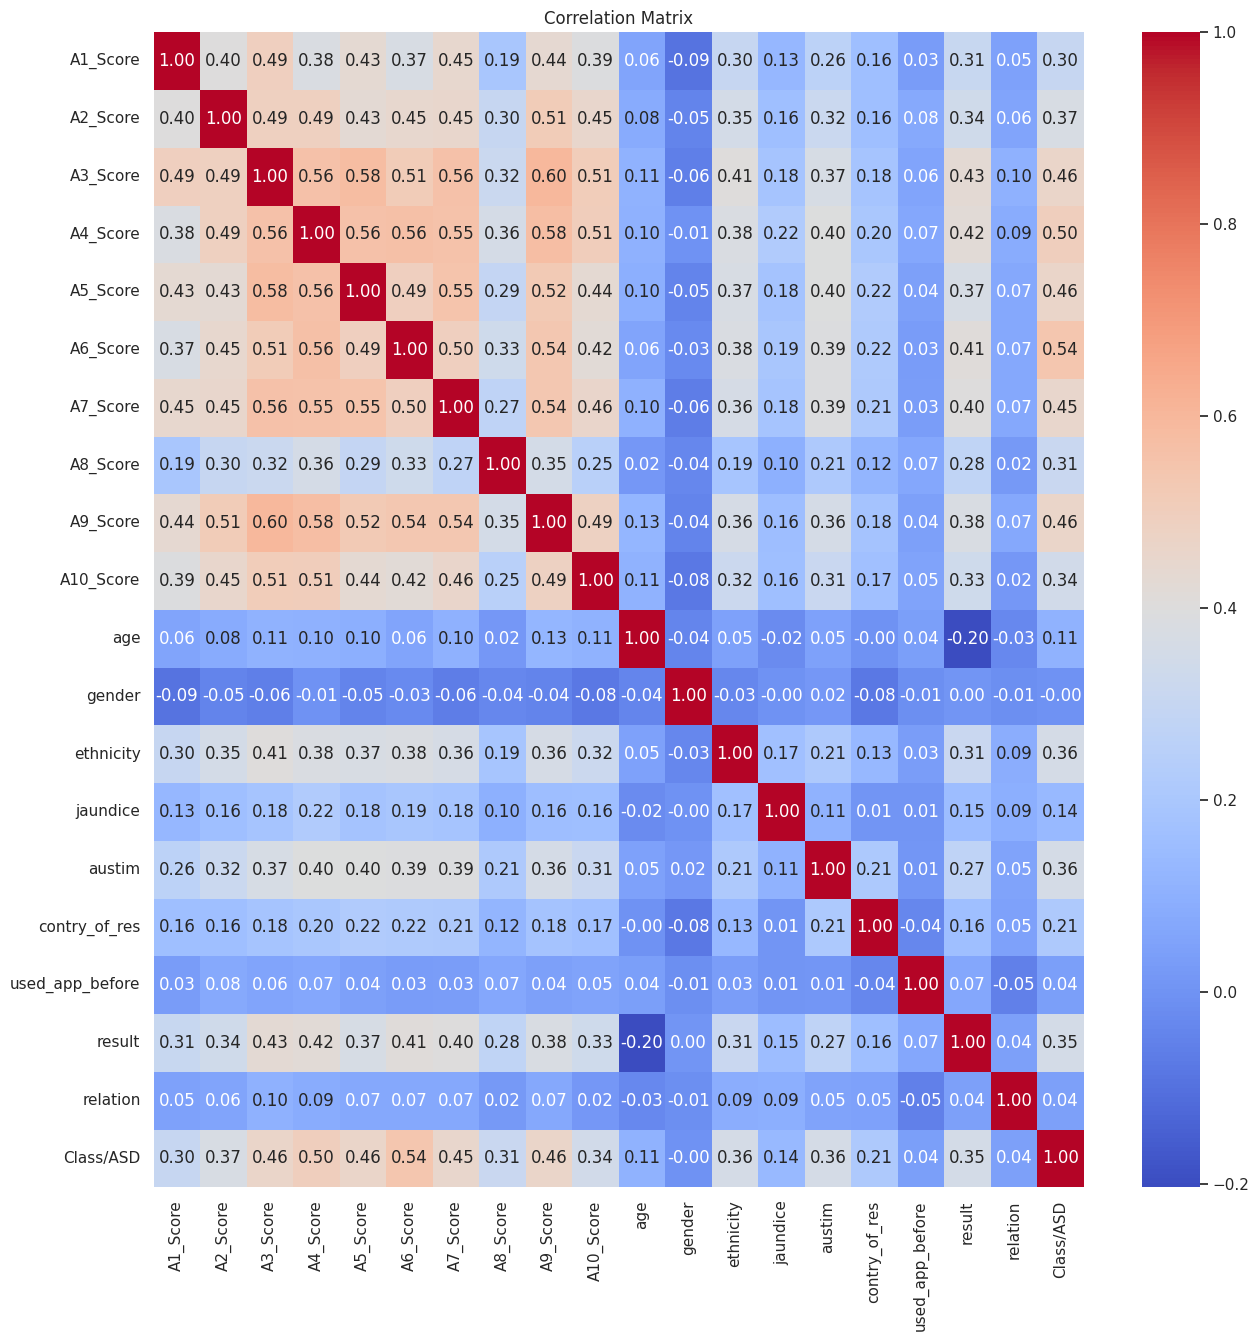

In [29]:
# correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Data Preprocessing


In [33]:
# function to replace the outliers with median
def replace_outliers_with_median(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  median = df[column].median()

  # replace outliers with median value
  df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

  return df

In [34]:
# replace outliers in the age column
df = replace_outliers_with_median(df, 'age')

# replace outliers in the result column
df = replace_outliers_with_median(df, 'result')

## Train Test Split

In [35]:
x = df.drop(columns=['Class/ASD'])
y = df['Class/ASD']

In [36]:
y

,Class/ASD
0,0
1,0
2,1
3,0
4,0
...,...
795,0
796,0
797,0
798,0


In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [38]:
y_test.value_counts()

,count
Class/ASD,
0,124
1,36


In [40]:
y_train.value_counts()

,count
Class/ASD,
0,515
1,125


SMOTE (Synthetic Minority Oversampling Technique)

In [41]:
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [48]:
print(y_train_smote.shape)

(1030,)


In [52]:
print(y_train_smote.value_counts())

Class/ASD
1    515
0    515
Name: count, dtype: int64


## Model Training

In [53]:
# dictionary of classifier
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
          }

In [54]:
# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} ...")
  scores = cross_val_score(model, x_train_smote, y_train_smote, cv=5, scoring='accuracy')
  cv_scores[model_name] = scores
  print(f"{model_name} Cross-Validation Accuracy: {np.mean(scores):.2f}")
  print("-"*50)

Training Decision Tree ...
Decision Tree Cross-Validation Accuracy: 0.86
--------------------------------------------------
Training Random Forest ...
Random Forest Cross-Validation Accuracy: 0.92
--------------------------------------------------
Training XGBoost ...
XGBoost Cross-Validation Accuracy: 0.90
--------------------------------------------------


## Model selection and hyperparameter tuning

In [57]:
# initializing modles
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
xgboost_classifier = XGBClassifier(random_state=42)

In [58]:
# hyperparameter grids for randomizesd SearchCV
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 50, 70],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

In [59]:
# hyperparrameter tuning


# the belowsteps can be automated by using a for loop or a pipeline


# perforem the randomized searchCV for each model
random_search_dt = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_grid_dt, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_rf = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid_rf, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_xgb = RandomizedSearchCV(estimator=xgboost_classifier, param_distributions=param_grid_xgb, n_iter=20, cv=5, scoring='accuracy', random_state=42)

In [60]:
# Fit the model
random_search_dt.fit(x_train_smote, y_train_smote)
random_search_rf.fit(x_train_smote, y_train_smote)
random_search_xgb.fit(x_train_smote, y_train_smote)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='accuracy')

In [61]:
# Get the model with the best score\
best_model = None
best_score = 0

if random_search_dt.best_score_ > best_score:
  best_score = random_search_dt.best_score_
  best_model = random_search_dt.best_estimator_

if random_search_rf.best_score_ > best_score:
  best_score = random_search_rf.best_score_
  best_model = random_search_rf.best_estimator_

if random_search_xgb.best_score_ > best_score:
  best_score = random_search_xgb.best_score_
  best_model = random_search_xgb.best_estimator_

In [62]:
print(f"Best Model: {best_model}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

Best Model: RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=5,
                       n_estimators=200, random_state=42)
Best Cross-Validation Accuracy: 0.92


In [63]:
# Save the best model
with open('best_model.pkl', 'wb') as f:
  pickle.dump(best_model, f)

## Model Evaluation

In [65]:
# Evaluate on test data
y_test_pred = best_model.predict(x_test)
print("Accuracy Score:\n", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy Score:
 0.81875
Confusion Matrix:
 [[109  15]
 [ 14  22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88       124
           1       0.59      0.61      0.60        36

    accuracy                           0.82       160
   macro avg       0.74      0.75      0.74       160
weighted avg       0.82      0.82      0.82       160

